In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.models as models
from i3d import I3D
import numpy as np
from matplotlib import pyplot as plt

In [3]:
import os
# datasets
from gluoncv.data import HMDB51
import mxnet.gluon.data
from mxnet.gluon.data.vision import transforms
from gluoncv.data.transforms import video

/data/luyi/anaconda3/lib/python3.8/site-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.9.1` and `torch==1.7.1+cu101` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
loss_train=[]
correct_train=[]
loss_test=[]
correct_test=[]
batchsize=5

Using cuda device


In [5]:
def get_scores(sample, model):
    out_var, out_logit = model(sample)
    out_tensor = out_var.data.cpu()

    top_val, top_idx = torch.sort(out_tensor, 1, descending=True)

    # print(
    #     'Top {} classes and associated probabilities: '.format(5))
    # for i in range(5):
    #     if top_idx[0, i]>51:
    #         continue
    #     print('[{}]: {:.6E}'.format(classes_list[top_idx[0, i]],
    #                                 top_val[0, i]))
    print(top_idx[:,0])
    return out_logit,top_idx[:,0]

In [6]:
def train_loop(data_loader, model, loss_fn, optimizer):
    batch=0
    #size=len(data_loader)*batchsize
    size=400*batchsize
    loss_sum=0
    correct_sum=0
    if(len(data_loader)<batchsize):
        return
    for x,y in data_loader:
        rgb_sample = x.asnumpy().squeeze()
        out_var, out_logit = model(torch.Tensor(rgb_sample).cuda())
        out_tensor = out_var.data.cpu()

        top_val, top_idx = torch.sort(out_tensor, 1, descending=True)
        out_label=top_idx[:,0]
        loss = loss_fn(out_logit, torch.tensor(y.asnumpy()).cuda())
       

        # Backpropagation
        optimizer.zero_grad()
        # loss.requires_grad_(True)
        loss.backward()
        optimizer.step()
        loss_sum+=loss.cpu().sum()
        correct_sum+=(y.asnumpy()==out_label.numpy()).sum()

        
        
        batch=batch+1
        if batch % 20 == 0:
            loss1, current = loss.item(), batch * batchsize
            print(f"Accuracy: {(100 * correct_sum/(batch*batchsize)):>0.1f}%,loss: {loss1:>7f} [{current:>5d}/{size:>5d}]")
        if batch==400:
            break
    loss_train.append(loss_sum/batch)
    correct_train.append(correct_sum/(batch*batchsize))


def test_loop(data_loader, model, loss_fn):
    batch=0
    size=len(data_loader)
    loss_sum=0
    correct_sum=0
    with torch.no_grad():
        for x,y in data_loader:
            rgb_sample = x.asnumpy().squeeze()
            out_var, out_logit = model(torch.Tensor(rgb_sample).cuda())
            out_tensor = out_var.data.cpu()

            top_val, top_idx = torch.sort(out_tensor, 1, descending=True)
            out_label=top_idx[:,0]
            loss = loss_fn(out_logit, torch.tensor(y.asnumpy()).cuda())
       
            loss_sum+=loss.cpu().sum()
            correct_sum+=(y.asnumpy()==out_label.numpy()).sum()
            batch=batch+1
            if batch % 20 == 0:
                print(batchsize*batch)
            if batch==100 :
                break
            
    loss_test.append(loss_sum/batch)
    correct_test.append(correct_sum/(batch*batchsize))
    print(f"Test Error: \n Accuracy: {(100 * correct_sum/(batch*batchsize)):>0.1f}%, Avg loss: {(loss_sum/batch):>8f} \n")
    return correct_sum/size

In [7]:
transform_train = transforms.Compose([
    video.VideoCenterCrop(size=224),
    video.VideoToTensor()
])

train_dataset = HMDB51(root='/data/luyi/lsx/datasets/hmdb51/rawframes',setting='/data/luyi/lsx/datasets/hmdb51/testTrainMulti_7030_splits/hmdb51_train_split_1_rawframes.txt',train=True, new_length=79, transform=transform_train)
train_data = mxnet.gluon.data.DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
test_dataset= HMDB51(root='/data/luyi/lsx/datasets/hmdb51/rawframes',setting='/data/luyi/lsx/datasets/hmdb51/testTrainMulti_7030_splits/hmdb51_val_split_1_rawframes.txt',train=False, new_length=79, transform=transform_train)
test_data = mxnet.gluon.data.DataLoader(test_dataset, batch_size=batchsize, shuffle=True)
# class_list
classes_list = os.listdir('/data/luyi/lsx/datasets/hmdb51/rawframes')
classes_list.sort()


In [8]:
rgb_weights_path='/data/luyi/lsx/code/model_weight/model_rgb.pth'

# rgb
print("rgb")
i3d_rgb = I3D(num_classes=len(classes_list), modality='rgb')#len(classes_list)
# weights initialize
orginal_dict = i3d_rgb.state_dict() #当前网络的权重字典。
weight_dict = torch.load(rgb_weights_path) #读取的网络权重字典
# 通过形状相同，把orignal_dict对应的tensor 换成 weight_dict的tensor。
i=0

list1=list(orginal_dict.keys())
list2=list(weight_dict.keys())
print(len(list1))
print(len(list2))
list1_not_in_list2 = [i for i in list1 if i not in list2]

list2_not_in_lis1 = [i for i in list2 if i not in list1]
print(len(list1_not_in_list2))
print("**************************************************")
print(len(list2_not_in_lis1))
for key2,value2 in weight_dict.items():
    if value2.size() == orginal_dict[key2].size():
        i=i+1
        orginal_dict[key2] = weight_dict[key2] # 将orginal换成weight_dict
i3d_rgb.load_state_dict(orginal_dict)

rgb
344
287
57
**************************************************
0


<All keys matched successfully>

In [9]:
for name, param in i3d_rgb.named_parameters():
    if "conv3d_0c_1x1" in name:
        print(type(param))
        print(name)
        param.requires_grad = True
        print("*****************true")
    else:
        param.requires_grad = False

i3d_rgb.train()
i3d_rgb.cuda()

epochs=20
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.SGD(i3d_rgb.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10, eps=1e-5)


<class 'torch.nn.parameter.Parameter'>
conv3d_0c_1x1.conv3d.weight
*****************true
<class 'torch.nn.parameter.Parameter'>
conv3d_0c_1x1.conv3d.bias
*****************true


In [10]:
import csv
def write(n,list):
    if n==0:
        strfile='loss_train1.csv'
    elif n==1:
        strfile='acc_train1.csv'
    elif n==2:
        strfile='loss_test1.csv'
    elif n==3:
        strfile='acc_test1.csv'
    with open(strfile, "w",newline='') as csv_file:
        writer = csv.writer(csv_file)
        for line in list:
            if line!='':  # 去除空行
                writer.writerow([line])


In [11]:
for t in range(5):
        print(f"Epoch {t + 1}\n-------------------------------")
        train_loop( train_data,  i3d_rgb, loss_fn, optimizer)
        print("test")
        accuracy=test_loop(train_data,  i3d_rgb, loss_fn)
        write(0,loss_train)
        write(1,correct_train)
        write(2,loss_test)
        write(3,correct_test)
        scheduler.step(accuracy)

Epoch 1
-------------------------------
Accuracy: 2.0%,loss: 3.874454 [  100/ 2000]
Accuracy: 1.5%,loss: 4.128220 [  200/ 2000]
Accuracy: 2.3%,loss: 3.955849 [  300/ 2000]
Accuracy: 2.2%,loss: 3.958649 [  400/ 2000]
Accuracy: 2.2%,loss: 3.871282 [  500/ 2000]
Accuracy: 3.2%,loss: 3.709567 [  600/ 2000]
Accuracy: 3.3%,loss: 3.831242 [  700/ 2000]
Accuracy: 3.9%,loss: 3.795001 [  800/ 2000]
Accuracy: 4.3%,loss: 3.746252 [  900/ 2000]
Accuracy: 5.3%,loss: 3.754831 [ 1000/ 2000]
Accuracy: 5.5%,loss: 3.834003 [ 1100/ 2000]
Accuracy: 6.4%,loss: 3.814866 [ 1200/ 2000]
Accuracy: 6.6%,loss: 3.840713 [ 1300/ 2000]
Accuracy: 7.3%,loss: 3.699836 [ 1400/ 2000]
Accuracy: 7.6%,loss: 3.770489 [ 1500/ 2000]
Accuracy: 8.4%,loss: 3.765321 [ 1600/ 2000]
Accuracy: 9.1%,loss: 3.746290 [ 1700/ 2000]
Accuracy: 10.0%,loss: 3.532059 [ 1800/ 2000]
Accuracy: 10.9%,loss: 3.761430 [ 1900/ 2000]
Accuracy: 11.6%,loss: 3.643094 [ 2000/ 2000]
test
100
200
300
400
500
Test Error: 
 Accuracy: 24.4%, Avg loss: 3.655588 



In [12]:
torch.save(i3d_rgb, 'net.pth')  # 保存整个神经网络的模型结构以及参数
torch.save(i3d_rgb.state_dict(), 'net_params.pkl')  # 同上

In [13]:
for t in range(5):
        print(f"Epoch {t + 6}\n-------------------------------")
        train_loop( train_data,  i3d_rgb, loss_fn, optimizer)
        print("test")
        accuracy=test_loop(train_data,  i3d_rgb, loss_fn)
        write(0,loss_train)
        write(1,correct_train)
        write(2,loss_test)
        write(3,correct_test)
        scheduler.step(accuracy)

Epoch 6
-------------------------------
Accuracy: 62.0%,loss: 2.685173 [  100/ 2000]
Accuracy: 64.5%,loss: 2.437493 [  200/ 2000]
Accuracy: 64.0%,loss: 2.558236 [  300/ 2000]
Accuracy: 63.2%,loss: 2.371097 [  400/ 2000]
Accuracy: 62.2%,loss: 2.319688 [  500/ 2000]
Accuracy: 59.8%,loss: 2.850130 [  600/ 2000]
Accuracy: 60.7%,loss: 2.247289 [  700/ 2000]
Accuracy: 61.4%,loss: 2.229406 [  800/ 2000]
Accuracy: 61.4%,loss: 2.568225 [  900/ 2000]
Accuracy: 61.2%,loss: 2.375446 [ 1000/ 2000]
Accuracy: 61.2%,loss: 3.017276 [ 1100/ 2000]
Accuracy: 61.2%,loss: 2.903866 [ 1200/ 2000]
Accuracy: 61.6%,loss: 3.074556 [ 1300/ 2000]
Accuracy: 62.0%,loss: 2.354405 [ 1400/ 2000]
Accuracy: 62.3%,loss: 2.193082 [ 1500/ 2000]
Accuracy: 62.0%,loss: 2.165103 [ 1600/ 2000]
Accuracy: 62.3%,loss: 2.967303 [ 1700/ 2000]
Accuracy: 61.9%,loss: 3.176954 [ 1800/ 2000]
Accuracy: 61.6%,loss: 2.321600 [ 1900/ 2000]
Accuracy: 61.5%,loss: 2.210942 [ 2000/ 2000]
test
100
200
300
400
500
Test Error: 
 Accuracy: 64.8%, Avg 

In [14]:
torch.save(i3d_rgb, 'net1.pth')  # 保存整个神经网络的模型结构以及参数
torch.save(i3d_rgb.state_dict(), 'net_params1.pkl')  # 同上

In [15]:
learning_rate=learning_rate*0.1
optimizer = torch.optim.SGD(i3d_rgb.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
for t in range(5):
        print(f"Epoch {t + 11}\n-------------------------------")
        train_loop( train_data,  i3d_rgb, loss_fn, optimizer)
        print("test")
        accuracy=test_loop(train_data,  i3d_rgb, loss_fn)
        write(0,loss_train)
        write(1,correct_train)
        write(2,loss_test)
        write(3,correct_test)
        scheduler.step(accuracy)

Epoch 11
-------------------------------
Accuracy: 64.0%,loss: 1.729779 [  100/ 2000]
Accuracy: 69.5%,loss: 2.181385 [  200/ 2000]
Accuracy: 70.3%,loss: 1.868733 [  300/ 2000]
Accuracy: 68.8%,loss: 3.239840 [  400/ 2000]
Accuracy: 71.4%,loss: 2.073669 [  500/ 2000]
Accuracy: 71.2%,loss: 1.973431 [  600/ 2000]
Accuracy: 71.3%,loss: 1.679882 [  700/ 2000]
Accuracy: 71.5%,loss: 2.202079 [  800/ 2000]
Accuracy: 70.8%,loss: 1.529565 [  900/ 2000]
Accuracy: 70.5%,loss: 2.277240 [ 1000/ 2000]
Accuracy: 70.5%,loss: 2.191327 [ 1100/ 2000]
Accuracy: 69.9%,loss: 2.055911 [ 1200/ 2000]
Accuracy: 70.2%,loss: 1.434158 [ 1300/ 2000]
Accuracy: 70.6%,loss: 1.437344 [ 1400/ 2000]
Accuracy: 70.7%,loss: 2.617788 [ 1500/ 2000]
Accuracy: 70.5%,loss: 1.658019 [ 1600/ 2000]
Accuracy: 70.2%,loss: 1.331750 [ 1700/ 2000]
Accuracy: 69.8%,loss: 1.809958 [ 1800/ 2000]
Accuracy: 69.8%,loss: 2.514552 [ 1900/ 2000]
Accuracy: 70.0%,loss: 2.383619 [ 2000/ 2000]
test
100
200
300
400
500
Test Error: 
 Accuracy: 70.2%, Avg

In [16]:
torch.save(i3d_rgb, 'net2.pth')  # 保存整个神经网络的模型结构以及参数
torch.save(i3d_rgb.state_dict(), 'net_params2.pkl')  # 同上

In [17]:
for t in range(5):
        print(f"Epoch {t + 16}\n-------------------------------")
        train_loop( train_data,  i3d_rgb, loss_fn, optimizer)
        print("test")
        accuracy=test_loop(train_data,  i3d_rgb, loss_fn)
        write(0,loss_train)
        write(1,correct_train)
        write(2,loss_test)
        write(3,correct_test)
        scheduler.step(accuracy)

Epoch 16
-------------------------------
Accuracy: 75.0%,loss: 1.775242 [  100/ 2000]
Accuracy: 72.5%,loss: 2.216937 [  200/ 2000]
Accuracy: 71.3%,loss: 1.477031 [  300/ 2000]
Accuracy: 71.8%,loss: 2.256917 [  400/ 2000]
Accuracy: 72.2%,loss: 2.180754 [  500/ 2000]
Accuracy: 72.2%,loss: 1.557953 [  600/ 2000]
Accuracy: 72.9%,loss: 1.629508 [  700/ 2000]
Accuracy: 72.5%,loss: 2.927517 [  800/ 2000]
Accuracy: 71.9%,loss: 2.548539 [  900/ 2000]
Accuracy: 72.2%,loss: 2.368445 [ 1000/ 2000]
Accuracy: 72.1%,loss: 2.714119 [ 1100/ 2000]
Accuracy: 72.1%,loss: 1.745767 [ 1200/ 2000]
Accuracy: 72.2%,loss: 1.378857 [ 1300/ 2000]
Accuracy: 72.5%,loss: 2.628683 [ 1400/ 2000]
Accuracy: 72.7%,loss: 1.778772 [ 1500/ 2000]
Accuracy: 72.8%,loss: 1.628671 [ 1600/ 2000]
Accuracy: 72.8%,loss: 1.626873 [ 1700/ 2000]
Accuracy: 72.8%,loss: 1.408045 [ 1800/ 2000]
Accuracy: 72.8%,loss: 1.672115 [ 1900/ 2000]
Accuracy: 72.4%,loss: 1.955449 [ 2000/ 2000]
test
100
200
300
400
500
Test Error: 
 Accuracy: 69.4%, Avg

In [18]:
torch.save(i3d_rgb, 'net3.pth')  # 保存整个神经网络的模型结构以及参数
torch.save(i3d_rgb.state_dict(), 'net_params3.pkl')  # 同上

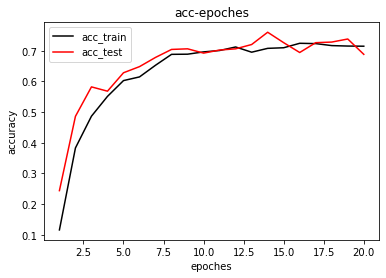

In [28]:
plt.xlabel("epoches")
plt.ylabel("accuracy")
plt.title('acc-epoches')
plt.plot(np.arange(1, 21),correct_train,color="black",label="acc_train")
plt.plot(np.arange(1, 21),correct_test,color="red",label="acc_test")
plt.legend()
plt.show()

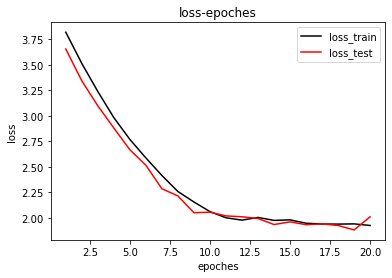

In [30]:
loss_train=[ 3.8198,   
 3.5140,   
 3.2386,   
 2.9827,   
 2.7693,   
 2.5876,   
 2.4154,   
 2.2583,   
 2.1557,   
 2.0615,   
 2.0010,   
 1.9778,   
 2.0045,   
 1.9753,   
 1.9809,   
 1.9474,   
 1.9400,   
 1.9390,   
 1.9411,   
 1.9254]
loss_test=[3.6556, 3.3437, 3.0986, 2.8808, 2.6677, 2.5157, 2.2857, 2.2151, 2.0504, 2.0558, 2.0194, 2.0106, 1.9942, 1.9346, 1.961, 1.9334, 1.9405, 1.9255, 1.882, 2.0105] 
plt.title('loss-epoches')
plt.xlabel("epoches")
plt.ylabel("loss")
plt.plot(np.arange(1, 21),loss_train,color="black",label="loss_train")
plt.plot(np.arange(1, 21),loss_test,color="red",label="loss_test")
plt.legend()
plt.show()
    
